In [1]:
import zCurve as z
import csv
import cv2
import os
import numpy as np
import pandas as pd
import glob
import json 
import matplotlib.pyplot as plt

from ultralytics import YOLO

In [2]:
def calculateMortonFromList_with_zCurve(values):
    # Cap floating point numbers to one decimal place and convert to integers
    int_values = [int(round(value, 1) * 10) for value in values]
    value = z.interlace(*int_values, dims=len(int_values))
    return value 

In [3]:
seq_path = '../datasets/better_smirk/left2right/three_cells/sq_00/'
config_path = '../config.json'

In [4]:
with open(config_path, 'r') as _f:
    config = json.load(_f)

In [5]:
config['attention_grid']["grid_left_top_coord"]

[[120, 200], [180, 200], [240, 200], [340, 200], [400, 200], [460, 200]]

In [23]:
rgb_path = os.path.join(seq_path, 'cam000020.png')

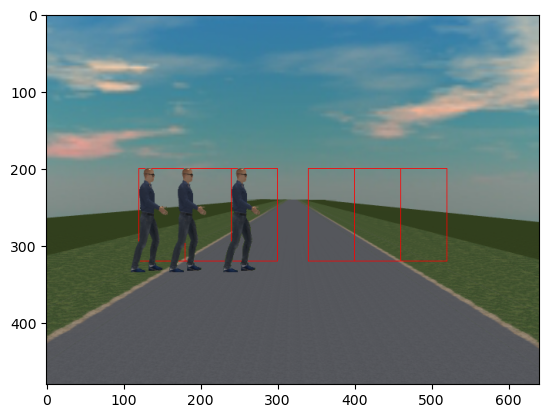

In [24]:
bgr = cv2.imread(rgb_path)
plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

In [6]:
attention_cells_start_cord = np.array(config['attention_grid']['grid_left_top_coord'])
attention_cell_width = config['attention_grid']['width']
attention_cell_height = config['attention_grid']['height']

In [7]:
attention_cells_end_cord = [start_piont + np.array([attention_cell_width, attention_cell_height]) for start_piont in attention_cells_start_cord]

In [46]:
yolo = YOLO("yolo11x.pt")  # load an official model
# Predict with the model
#results = yolo([rgb_path, os.path.join(seq_path,'cam000202.png')])
results = yolo.predict(rgb_path, verbose=False)

In [47]:
yolo_start_point = []
yolo_end_point = []
for result in results:
    # result.show()
    result = result.boxes.cpu().numpy()
    if result.data.size > 0:
        xyxy = result.xyxy.astype(np.int64)
        xywh = result.xywh.astype(np.int64)
        for i in range(len(xyxy)):
            yolo_start_point.append([xyxy[i][0], xyxy[i][1]])
            yolo_end_point.append([xyxy[i][2], xyxy[i][3]])
    else:
        yolo_start_point = None
        yolo_end_point = None

    

In [48]:
print(yolo_start_point)
print(yolo_end_point)

[[230, 199], [109, 199], [159, 199]]
[[278, 334], [158, 335], [208, 334]]


In [8]:
def overlap(cell_cord, yolo_cord): # [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    x_left = max(cell_cord[0], yolo_cord[0])
    x_right = min(cell_cord[2], yolo_cord[2])
    y_top = max(cell_cord[1], yolo_cord[1])
    y_bottom = min(cell_cord[3], yolo_cord[3])

    if x_right < x_left or y_bottom < y_top:
        return 0, 0, 0, 0, 0
    overlap_area = (x_right - x_left) * (y_bottom - y_top)
    return overlap_area, x_left, y_top, x_right, y_bottom

In [66]:
if yolo_start_point is not None and yolo_end_point is not None:
    yolo_coord_all = np.concatenate([yolo_start_point, yolo_end_point], axis=1)
    print(yolo_coord_all)
else: 
    yolo_coord_all = [0,0,0,0]

[[230 199 278 334]
 [109 199 158 335]
 [159 199 208 334]]


In [51]:
cell_coord_all = np.concatenate([attention_cells_start_cord, attention_cells_end_cord], axis=1)
cell_coord_all

array([[120, 200, 180, 320],
       [180, 200, 240, 320],
       [240, 200, 300, 320],
       [340, 200, 400, 320],
       [400, 200, 460, 320],
       [460, 200, 520, 320]])

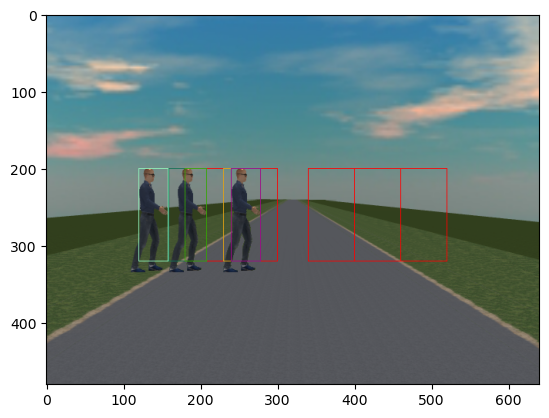

In [67]:
bgr_copy = bgr.copy()
for i in range(len(cell_coord_all)):
    cell_coord = cell_coord_all[i]
    overlap_cum = 0
    for j in yolo_coord_all:
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)
        
        color = list(np.random.random(size=3) * 256)
        rgb_overlap = cv2.rectangle(bgr_copy, [x_left, y_top], [x_right, y_bottom], color, 1)
        
        overlap_cum += overlap_area
        #print(overlap_area, x_left, y_top, x_right, y_bottom)
    #print(overlap_cum)

    #break
plt.imshow(cv2.cvtColor(bgr_copy, cv2.COLOR_BGR2RGB))

In [68]:
input_zcurve = np.zeros(6)
for i in range(len(cell_coord_all)):
    cell_coord = cell_coord_all[i]
    overlap_cum = 0
    for j in yolo_coord_all:
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)    
        overlap_cum += overlap_area

    cell_area = config['attention_grid']['width'] * config['attention_grid']['height']
    if overlap_cum > 0:
        input_zcurve[i] = overlap_cum / cell_area
    
    print(overlap_cum, cell_area, x_left, y_top, x_right, y_bottom)
print(input_zcurve)

7080 7200 159 200 180 320
4560 7200 180 200 208 320
4560 7200 0 0 0 0
0 7200 0 0 0 0
0 7200 0 0 0 0
0 7200 0 0 0 0
[    0.98333     0.63333     0.63333           0           0           0]


In [70]:
morton = calculateMortonFromList_with_zCurve(input_zcurve)
morton

287168

### Combine everything to process all images in a sequence. 

In [ ]:
morton_codes = []
for anno_frame in sorted(glob.glob(os.path.join(seq_path, '*.labels.png'))):
    rgb_frame = anno_frame.replace('.labels.png', '.png')
    yolo_start_point = []
    yolo_end_point = []
    yolo = YOLO("yolo11x.pt") 
    results = yolo.predict(rgb_frame, verbose=False)
    for result in results:
        result = result.boxes.cpu().numpy()
        if result.data.size > 0:
            xyxy = result.xyxy.astype(np.int64)
            xywh = result.xywh.astype(np.int64)
            for i in range(len(xyxy)):
                yolo_start_point.append([xyxy[i][0], xyxy[i][1]])
                yolo_end_point.append([xyxy[i][2], xyxy[i][3]])
        else:
            yolo_start_point = None
            yolo_end_point = None

    if yolo_start_point is not None and yolo_end_point is not None:
        yolo_coord_all = np.concatenate([yolo_start_point, yolo_end_point], axis=1)
    else: 
        yolo_coord_all = [0,0,0,0]
        
    cell_coord_all = np.concatenate([attention_cells_start_cord, attention_cells_end_cord], axis=1)

    bgr = cv2.imread(rgb_frame)

    input_zcurve = np.zeros(6)
    for i in range(len(cell_coord_all)):
        cell_coord = cell_coord_all[i]
        overlap_cum = 0
        for j in yolo_coord_all:
            overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)
            color = list(np.random.random(size=3) * 256)
            bgr_overlap = cv2.rectangle(bgr, [x_left, y_top], [x_right, y_bottom], color, 1)
            overlap_cum += overlap_area
        
        cell_area = config['attention_grid']['width'] * config['attention_grid']['height']
        if overlap_cum > 0:
            input_zcurve[i] = overlap_cum / cell_area
    
    overlap_path = rgb_frame.replace('datasets/better_smirk', 'outputs/yolo_better_smirk')
    if not os.path.exists(os.path.dirname(overlap_path)):
        os.makedirs(os.path.dirname(overlap_path))
    cv2.imwrite(overlap_path, bgr_overlap)

    morton_bgr = calculateMortonFromList_with_zCurve(input_zcurve)
    morton_codes.append({'frame': rgb_frame, 'morton': morton_bgr})

morton_codes = pd.DataFrame(morton_codes, columns=['frame', 'morton'])
morton_codes.to_csv('../outputs/yolo_morton_better_smirk.csv', sep=';', index=False)

### Read the saved csv and plot

In [13]:
morton_codes_yolo_proportion = pd.read_csv('../outputs/yolo_morton_better_smirk.csv', sep=';')
morton_codes_yolo_proportion = morton_codes_yolo_proportion.to_numpy()

In [16]:
mortons_seq = []
for i in range(len(morton_codes_yolo_proportion)):
    frame, morton = morton_codes_yolo_proportion[i]
    mortons_seq.append(int(morton)/10000)
print(mortons_seq)

[1.2353, 1.2353, 27.0464, 27.0466, 1.2354, 1.248, 1.229, 52.8448, 78.6565, 78.6503, 78.6755, 78.6752, 27.0534, 27.0786, 27.079, 80.2881, 80.6916, 80.3137, 28.6849, 28.6722, 28.7168, 28.7172, 183.936, 183.5457, 183.5076, 183.5011, 183.5008, 54.5221, 157.7154, 157.7154, 157.7091, 54.5026, 54.4772, 54.0741, 54.112, 158.1128, 158.1569, 158.1576, 54.1572, 54.1444, 157.3384, 160.5636, 109.0438, 109.0436, 108.9676, 109.0054, 109.0048, 315.4176, 314.663, 316.2248, 314.6132, 314.5986, 108.1868, 108.1876, 108.2884, 321.1264, 321.128, 218.0356, 11.5472, 11.5472, 11.6252, 11.6248, 630.7856, 629.274, 422.7848, 629.1712, 9.9868, 216.3768, 629.4056, 642.3048, 642.308, 216.6304, 229.5296, 229.5296, 229.736, 1468.0584, 1468.0584, 1468.0616, 229.6872, 229.6864, 1468.0064, 1468.0064, 1261.724, 1261.7232, 436.1728, 436.1224, 436.1216, 436.1248, 1258.4472, 1258.4464, 1258.4464, 432.7448, 432.5408, 432.5408, 432.7472, 1258.5008, 1271.3984, 858.6256, 845.7216, 845.7216]


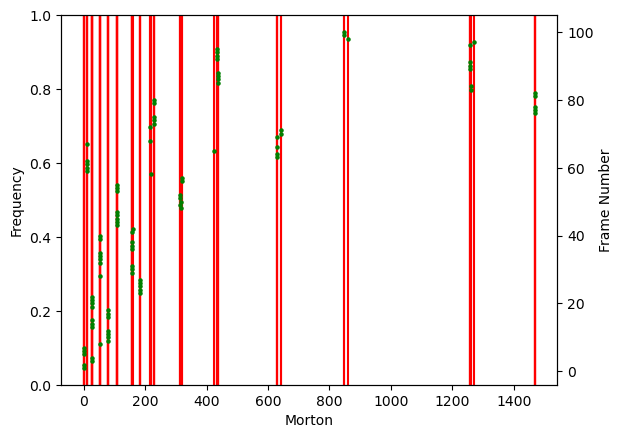

In [22]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("Morton")
ax1.set_ylabel("Frequency")
ax1.set_ylim((0, 1))
ax1.eventplot(mortons_seq, orientation='horizontal', colors="red",lineoffsets=0.5)

ax2 = ax1.twinx()
for frame_id in range(len(mortons_seq)):
    x=mortons_seq[frame_id]
    y=frame_id+1
    ax2.scatter(x, y, s=5, color='green')
    ax2.set_ylabel("Frame Number")

#fig.savefig('asas.png')